# Example 3: RVT Peak Calculators

Use RVT input motion with:
1. Boore & Thompson (2012) -- based on Cartwright and Longuet-Higgins (56) peak factor with corrections for oscillator duration 
2. Boore & Thompson (2015) -- based on Vanmarcke (75) peak factor with corrections for oscillator duration
3. Wang & Rathje (2018) --  based on Vanmarcke (75) peak factor with corrections for oscillator duration and site transfer function

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
def create_motion(calculator):
    mag = 7.0
    dist = 30.0
    region = 'wna'
    m = pysra.motion.SourceTheoryRvtMotion(
        mag, dist, region, 
        peak_calculator=calculator, 
        # These calculators need to know about the event for the RMS duration correction
        calc_kwds={
            'region': region,
            'mag': mag,
            'dist': dist,
        }
    )
    return m

calculator_names = ['BT12', 'BT15', 'WR18']
motions = [create_motion(cn) for cn in calculator_names]

In [4]:
for m in motions:
    m.calc_fourier_amps()

## Create site profile

Create a simple soil profile with a single soil layer with nonlinear properties defined by the Darendeli nonlinear model.

In [5]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.SoilType('Soil', 18., None, 0.02),
        300, 600
    ),
    pysra.site.Layer(
        pysra.site.SoilType(
            'Rock', 24., None, 0.01
        ),
        0, 2000
    ),
])

## Create the site response calculator

In [6]:
calc = pysra.propagation.LinearElasticCalculator()

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)
outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05)
])

## Perform the calculation

Compute the response of the site, and store the state within the calculation object. Use the calculator, to compute the outputs.

In [8]:
for m in motions:
    calc(m, profile, profile.location('outcrop', index=-1))
    outputs(calc, m.peak_calculator.ABBREV)

## Plot the outputs

Create a few plots of the output.

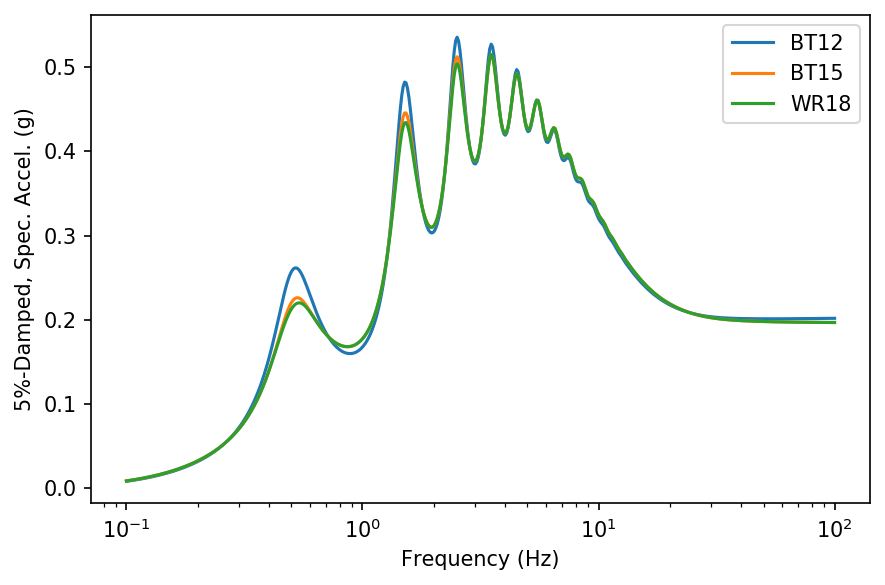

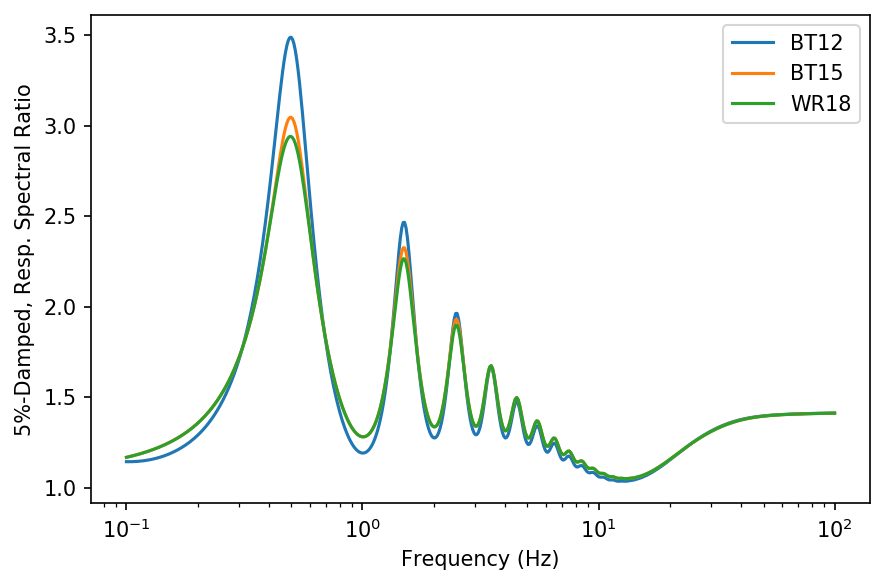

In [9]:
for output in outputs:
    fig, ax = plt.subplots(dpi=150)
    for name, refs, values in output.iter_results():
        ax.plot(refs, values, label=name)
    ax.set(xlabel=output.xlabel, xscale='log', ylabel=output.ylabel)
    ax.legend()
    fig.tight_layout();